# Project of NLP : Translation English -> French

## Importing tools

In [ ]:
import os
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
import pandas as pd
import numpy as np

import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

import string
import re
from pickle import dump
from unicodedata import normalize


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


## Loading the data

In [ ]:

def load_doc(filename):
	file = open(filename, mode='rt', encoding='utf-8')
	text = file.read()
	file.close()
	return text
 
def to_sentences(doc):
	return doc.strip().split('\n')
 
# clean a list of lines
def clean_lines(lines):
	cleaned = list()
	# prepare regex for char filtering
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for line in lines:
		# normalize unicode characters
		line = normalize('NFD', line).encode('ascii', 'ignore')
		line = line.decode('UTF-8')
		# tokenize on white space
		line = line.split()
		# convert to lower case
		line = [word.lower() for word in line]
		# remove punctuation from each token
		line = [word.translate(table) for word in line]
		# remove non-printable chars form each token
		line = [re_print.sub('', w) for w in line]
		# remove tokens with numbers in them
		line = [word for word in line if word.isalpha()]
		# store as string
		cleaned.append(' '.join(line))
	return cleaned
 
# save a list of clean sentences to file
def save_clean_sentences(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)
 
# load English data
filename = 'europarl-v7.fr-en.en'
doc = load_doc(filename)
sentencesEn = to_sentences(doc)
sentences_english = clean_lines(sentencesEn)
save_clean_sentences(sentences_english, 'english.pkl')
# spot check
for i in range(10):
	print(sentences_english[i])
 
# load French data
filename = 'europarl-v7.fr-en.fr'
doc = load_doc(filename)
sentencesFr = to_sentences(doc)
sentences_french = clean_lines(sentencesFr)
save_clean_sentences(sentences_french, 'french.pkl')
# spot check
for i in range(10):
	print(sentences_french[i])

Saved: english.pkl
resumption of the session
i declare resumed the session of the european parliament adjourned on friday december and i would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period
although as you will have seen the dreaded millennium bug failed to materialise still the people in a number of countries suffered a series of natural disasters that truly were dreadful
you have requested a debate on this subject in the course of the next few days during this partsession
in the meantime i should like to observe a minute s silence as a number of members have requested on behalf of all the victims concerned particularly those of the terrible storms in the various countries of the european union
please rise then for this minute s silence
the house rose and observed a minute s silence
madam president on a point of order
you will be aware from the press and television that there have been a number of bomb explosions and killings in sri

In [ ]:
list_french = []
for i in range(500):
    list_french.append(sentences_french[i])
print(list_french)

list_english = []
for i in range(500):
    list_english.append(sentences_english[i])
print(list_english)

['reprise de la session', 'je declare reprise la session du parlement europeen qui avait ete interrompue le vendredi decembre dernier et je vous renouvelle tous mes vux en esperant que vous avez passe de bonnes vacances', 'comme vous avez pu le constater le grand bogue de lan ne sest pas produit en revanche les citoyens dun certain nombre de nos pays ont ete victimes de catastrophes naturelles qui ont vraiment ete terribles', 'vous avez souhaite un debat a ce sujet dans les prochains jours au cours de cette periode de session', 'en attendant je souhaiterais comme un certain nombre de collegues me lont demande que nous observions une minute de silence pour toutes les victimes des tempetes notamment dans les differents pays de lunion europeenne qui ont ete touches', 'je vous invite a vous lever pour cette minute de silence', 'le parlement debout observe une minute de silence', 'madame la presidente cest une motion de procedure', 'vous avez probablement appris par la presse et par la tele

## Creating a Dataframe 

In [ ]:
df = pd.DataFrame(list(zip(list_english, list_french)), columns =['english', 'french'])
df

,english,french
0,resumption of the session,reprise de la session
1,i declare resumed the session of the european parliament adjourned on friday december and i would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period,je declare reprise la session du parlement europeen qui avait ete interrompue le vendredi decembre dernier et je vous renouvelle tous mes vux en esperant que vous avez passe de bonnes vacances
2,although as you will have seen the dreaded millennium bug failed to materialise still the people in a number of countries suffered a series of natural disasters that truly were dreadful,comme vous avez pu le constater le grand bogue de lan ne sest pas produit en revanche les citoyens dun certain nombre de nos pays ont ete victimes de catastrophes naturelles qui ont vraiment ete terribles
3,you have requested a debate on this subject in the course of the next few days during this partsession,vous avez souhaite un debat a ce sujet dans les prochains jours au cours de cette periode de session
4,in the meantime i should like to observe a minute s silence as a number of members have requested on behalf of all the victims concerned particularly those of the terrible storms in the various countries of the european union,en attendant je souhaiterais comme un certain nombre de collegues me lont demande que nous observions une minute de silence pour toutes les victimes des tempetes notamment dans les differents pays de lunion europeenne qui ont ete touches
5,please rise then for this minute s silence,je vous invite a vous lever pour cette minute de silence
6,the house rose and observed a minute s silence,le parlement debout observe une minute de silence
7,madam president on a point of order,madame la presidente cest une motion de procedure
8,you will be aware from the press and television that there have been a number of bomb explosions and killings in sri lanka,vous avez probablement appris par la presse et par la television que plusieurs attentats a la bombe et crimes ont ete perpetres au sri lanka
9,one of the people assassinated very recently in sri lanka was mr kumar ponnambalam who had visited the european parliament just a few months ago,lune des personnes qui vient detre assassinee au sri lanka est m kumar ponnambalam qui avait rendu visite au parlement europeen il y a quelques mois a peine


#### Lowercase all characters


In [ ]:
df['english']=df['english'].apply(lambda x: x.lower())
df['french']=df['french'].apply(lambda x: x.lower())

#### data cleaning

In [ ]:
# Set of all special characters
exclude = set(string.punctuation) 
# Remove all the special characters
df['english']=df['english'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
df['french']=df['french'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))


In [ ]:
# Remove quotes
df['english']=df['english'].apply(lambda x: re.sub("'", '', x))
df['french']=df['french'].apply(lambda x: re.sub("'", '', x))


In [ ]:
remove_digits = str.maketrans('', '', digits)
df['english']=df['english'].apply(lambda x: x.translate(remove_digits))
df['french']=df['french'].apply(lambda x: x.translate(remove_digits))

In [ ]:
# Remove extra spaces
df['english']=df['english'].apply(lambda x: x.strip())
df['french']=df['french'].apply(lambda x: x.strip())
df['english']=df['english'].apply(lambda x: re.sub(" +", " ", x))
df['french']=df['french'].apply(lambda x: re.sub(" +", " ", x))

In [ ]:
# Add start and end tokens to target sequences
df['french'] = df['french'].apply(lambda x : 'START_ '+ x + ' _END')

In [ ]:
### Get English and French Vocabulary
all_eng_words=set()
for eng in df['english']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_french_words=set()
for fr in df['french']:
    for word in fr.split():
        if word not in all_french_words:
            all_french_words.add(word)

In [ ]:
df['length_eng_sentence']=df['english'].apply(lambda x:len(x.split(" ")))
df['length_fr_sentence']=df['french'].apply(lambda x:len(x.split(" ")))

In [ ]:
df

,english,french,length_eng_sentence,length_fr_sentence
0,resumption of the session,START_ reprise de la session _END,4,6
1,i declare resumed the session of the european parliament adjourned on friday december and i would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period,START_ je declare reprise la session du parlement europeen qui avait ete interrompue le vendredi decembre dernier et je vous renouvelle tous mes vux en esperant que vous avez passe de bonnes vacances _END,36,34
2,although as you will have seen the dreaded millennium bug failed to materialise still the people in a number of countries suffered a series of natural disasters that truly were dreadful,START_ comme vous avez pu le constater le grand bogue de lan ne sest pas produit en revanche les citoyens dun certain nombre de nos pays ont ete victimes de catastrophes naturelles qui ont vraiment ete terribles _END,31,38
3,you have requested a debate on this subject in the course of the next few days during this partsession,START_ vous avez souhaite un debat a ce sujet dans les prochains jours au cours de cette periode de session _END,19,21
4,in the meantime i should like to observe a minute s silence as a number of members have requested on behalf of all the victims concerned particularly those of the terrible storms in the various countries of the european union,START_ en attendant je souhaiterais comme un certain nombre de collegues me lont demande que nous observions une minute de silence pour toutes les victimes des tempetes notamment dans les differents pays de lunion europeenne qui ont ete touches _END,40,40
5,please rise then for this minute s silence,START_ je vous invite a vous lever pour cette minute de silence _END,8,13
6,the house rose and observed a minute s silence,START_ le parlement debout observe une minute de silence _END,9,10
7,madam president on a point of order,START_ madame la presidente cest une motion de procedure _END,7,10
8,you will be aware from the press and television that there have been a number of bomb explosions and killings in sri lanka,START_ vous avez probablement appris par la presse et par la television que plusieurs attentats a la bombe et crimes ont ete perpetres au sri lanka _END,23,27
9,one of the people assassinated very recently in sri lanka was mr kumar ponnambalam who had visited the european parliament just a few months ago,START_ lune des personnes qui vient detre assassinee au sri lanka est m kumar ponnambalam qui avait rendu visite au parlement europeen il y a quelques mois a peine _END,25,30


In [ ]:
df[df['length_eng_sentence']>30].shape

(171, 4)

In [ ]:
df=df[df['length_eng_sentence']<=20]
df=df[df['length_fr_sentence']<=20]

In [ ]:
print("maximum length of french Sentence ",max(df['length_fr_sentence']))
print("maximum length of English Sentence ",max(df['length_eng_sentence']))

maximum length of french Sentence  20
maximum length of English Sentence  20


In [ ]:
max_length_src=max(df['length_fr_sentence'])
max_length_tar=max(df['length_eng_sentence'])

In [ ]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_french_words))
num_encoder_tokens = len(all_eng_words)+1
num_decoder_tokens = len(all_french_words)
num_encoder_tokens, num_decoder_tokens

(2278, 2830)

In [ ]:
num_decoder_tokens += 1 #for zero padding

In [ ]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [ ]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [ ]:
X, y = df['english'], df['french']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)
X_train.shape, X_test.shape

((137,), (35,))

In [ ]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')

In [ ]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

## Architecture of Encoder-Decoder

In [ ]:
latent_dim=200

In [ ]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

encoder_states = [state_h, state_c]

In [ ]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Defining the model 

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    455600      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    566200      input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 10
epochs = 100

In [ ]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size ,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)


/shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
Epoch 1/100
13/13 [==============================] - 19s 635ms/step - loss: 4.9281 - accuracy: 0.0584 - val_loss: 3.7887 - val_accuracy: 0.0922
Epoch 2/100
13/13 [==============================] - 4s 292ms/step - loss: 3.6483 - accuracy: 0.0850 - val_loss: 3.8008 - val_accuracy: 0.0978
Epoch 3/100
13/13 [==============================] - 4s 312ms/step - loss: 3.4178 - accuracy: 0.1010 - val_loss: 3.8579 - val_accuracy: 0.1006
Epoch 4/100
13/13 [==============================] - 4s 291ms/step - loss: 3.3539 - accuracy: 0.1046 - val_loss: 3.8975 - val_accuracy: 0.1034
Epoch 5/100
13/13 [==============================] - 4s 298ms/step - loss: 3.2658 - accuracy: 0.1136 - val_loss: 3.9240 - va

In [ ]:
model.save_weights('nmt_weights.h5')

In [ ]:

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence


decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) 

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [ ]:
def decode_sequence(input_seq):
    
    states_value = encoder_model.predict(input_seq)
  
    target_seq = np.zeros((1,1))
    
    target_seq[0, 0] = target_token_index['START_']

   
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        
        if (sampled_char == '_END' or
           len(decoded_sentence) > 100):
            stop_condition = True

       
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        
        states_value = [h, c]

    return decoded_sentence

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual French Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted French Translation:', decoded_sentence[:-4])

Input English sentence: that is why my group moves that this item be taken off the agenda
Actual French Translation:  cest pourquoi mon groupe demande que ce point soit retire de lordre du jour 
Predicted French Translation:  cest pourquoi mon groupe demande que ce point soit retire de lordre du jour 


## Comparison with known models

In [ ]:
# Load English data
english_sentences_new_model = sentencesEn[:500]
# Load French data
french_sentences_new_model = sentencesFr[:500]

print('Dataset Loaded')

Dataset Loaded


In [ ]:
print('small_vocab_en Line {}:  {}'.format(1, english_sentences_new_model[1]))
print('small_vocab_fr Line {}:  {}'.format(1, french_sentences_new_model[1]))

small_vocab_en Line 1:  I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.
small_vocab_fr Line 1:  Je déclare reprise la session du Parlement européen qui avait été interrompue le vendredi 17 décembre dernier et je vous renouvelle tous mes vux en espérant que vous avez passé de bonnes vacances.


In [ ]:
import collections

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

In [ ]:
X_train_english, X_test_english, y_train_french, y_test_french = train_test_split(english_sentences_new_model, french_sentences_new_model, test_size = 0.2,random_state=42)

In [ ]:
def tokenize(x):
 
    x_tk = Tokenizer(char_level = False)
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk


In [ ]:
def pad(x, length=None):
    
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'post')


In [ ]:
def preprocess(x, y):

    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(X_train_english, y_train_french)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)+1


In [ ]:
def logits_to_text(logits, tokenizer):
  
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])


### Simple RNN model

In [ ]:

def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
 
    learning_rate = 0.01
    input_seq = Input(input_shape[1:])
    rnn = GRU(64, return_sequences = True)(input_seq)
    logits = TimeDistributed(Dense(french_vocab_size))(rnn)
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate), 
                 metrics = ['accuracy'])
    
    return model

# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))


# Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

simple_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=10, epochs=10, validation_split=0.2)

print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

Epoch 1/10
32/32 [==============================] - 11s 265ms/step - loss: 5.0158 - accuracy: 0.6889 - val_loss: 2.0081 - val_accuracy: 0.7261
Epoch 2/10
32/32 [==============================] - 7s 232ms/step - loss: 1.9211 - accuracy: 0.7180 - val_loss: 1.9898 - val_accuracy: 0.7267
Epoch 3/10
32/32 [==============================] - 8s 238ms/step - loss: 1.8299 - accuracy: 0.7267 - val_loss: 1.9866 - val_accuracy: 0.7274
Epoch 4/10
32/32 [==============================] - 7s 231ms/step - loss: 1.8800 - accuracy: 0.7182 - val_loss: 1.9973 - val_accuracy: 0.7284
Epoch 5/10
32/32 [==============================] - 7s 230ms/step - loss: 1.7995 - accuracy: 0.7258 - val_loss: 2.0124 - val_accuracy: 0.7293
Epoch 6/10
32/32 [==============================] - 8s 243ms/step - loss: 1.8001 - accuracy: 0.7254 - val_loss: 2.0273 - val_accuracy: 0.7297
Epoch 7/10
32/32 [==============================] - 8s 246ms/step - loss: 1.6847 - accuracy: 0.7390 - val_loss: 2.0508 - val_accuracy: 0.7302
Epoch

### Bidirectional RNN model

In [ ]:
from keras.models import Sequential
def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    
    learning_rate = 1e-3
    model = Sequential()
    model.add(Bidirectional(GRU(128, return_sequences = True, dropout = 0.1), 
                           input_shape = input_shape[1:]))
    model.add(TimeDistributed(Dense(french_vocab_size, activation = 'softmax')))
    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate), 
                 metrics = ['accuracy'])
    return model


tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

bidi_model = bd_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)


bidi_model.fit(tmp_x, preproc_french_sentences, batch_size=10, epochs=10, validation_split=0.2)

print(logits_to_text(bidi_model.predict(tmp_x[:1])[0], french_tokenizer))

Epoch 1/10
32/32 [==============================] - 23s 577ms/step - loss: 7.1014 - accuracy: 0.6638 - val_loss: 2.1384 - val_accuracy: 0.7287
Epoch 2/10
32/32 [==============================] - 16s 505ms/step - loss: 1.9944 - accuracy: 0.7253 - val_loss: 1.9923 - val_accuracy: 0.7332
Epoch 3/10
32/32 [==============================] - 15s 484ms/step - loss: 1.8575 - accuracy: 0.7275 - val_loss: 1.9776 - val_accuracy: 0.7334
Epoch 4/10
32/32 [==============================] - 16s 511ms/step - loss: 1.8986 - accuracy: 0.7174 - val_loss: 1.9828 - val_accuracy: 0.7370
Epoch 5/10
32/32 [==============================] - 16s 503ms/step - loss: 1.8978 - accuracy: 0.7163 - val_loss: 1.9841 - val_accuracy: 0.7355
Epoch 6/10
32/32 [==============================] - 17s 532ms/step - loss: 1.7255 - accuracy: 0.7381 - val_loss: 1.9878 - val_accuracy: 0.7362
Epoch 7/10
32/32 [==============================] - 16s 513ms/step - loss: 1.8452 - accuracy: 0.7193 - val_loss: 1.9986 - val_accuracy: 0.7373

## Comparison - Plot

### Comparing our model with different hyperparameters

In [ ]:
#accuracy_NumberOfSentences_BatchSize[10-30-50-100]epochs

accuracy_500_10 = [0.1683 , 0.4655  ,0.8792  ,0.9705  ]
accuracy_500_50 = [0.1014 , 0.1098, 0.1191,0.1996]
accuracy_500_100= [0.2202,0.2135,0.3440,0.4382]

accuracy_250_10 = [0.1149 ,0.1540 ,0.3130 , 0.9497 ]
accuracy_250_50 =[0.1042,0.3139,0.4223,0.7265]


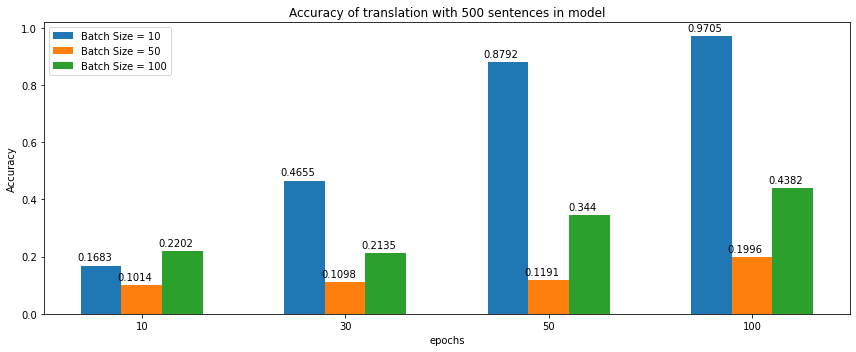

In [ ]:

labels = [10,30,50,100]


x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12,5))
rects1 = ax.bar(x - width, accuracy_500_10, width, label='Batch Size = 10')
rects2 = ax.bar(x , accuracy_500_50, width, label='Batch Size = 50')
rects3 = ax.bar(x + width, accuracy_500_100, width, label='Batch Size = 100')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of translation with 500 sentences in model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 3, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

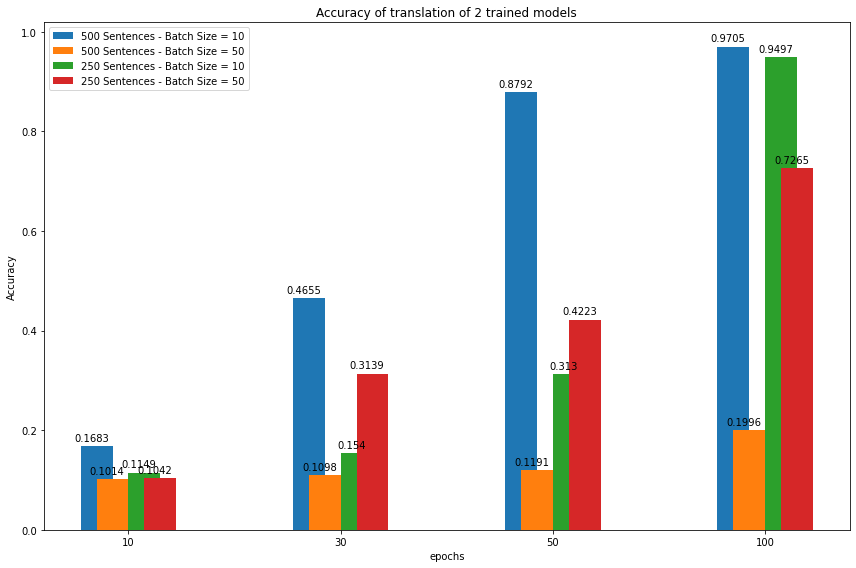

In [ ]:
labels = [10,30,50,100]


x = np.arange(len(labels))
width = 0.15

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width, accuracy_500_10, width, label='500 Sentences - Batch Size = 10')
rects2 = ax.bar(x - width/2, accuracy_500_50, width, label='500 Sentences - Batch Size = 50')
rects3 = ax.bar(x + width/2, accuracy_250_10, width, label='250 Sentences - Batch Size = 10')
rects4 = ax.bar(x + width, accuracy_250_50, width, label='250 Sentences - Batch Size = 50')


ax.set_xlabel('epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of translation of 2 trained models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 3, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.show()

## Other optimizers

In [ ]:
accuracy_Adamax = [0.0973 ,0.1194 ,0.1285 , 0.1811 ]
accuracy_SGD = [0.0831 ,0.1008 , 0.0971 , 0.1044 ]

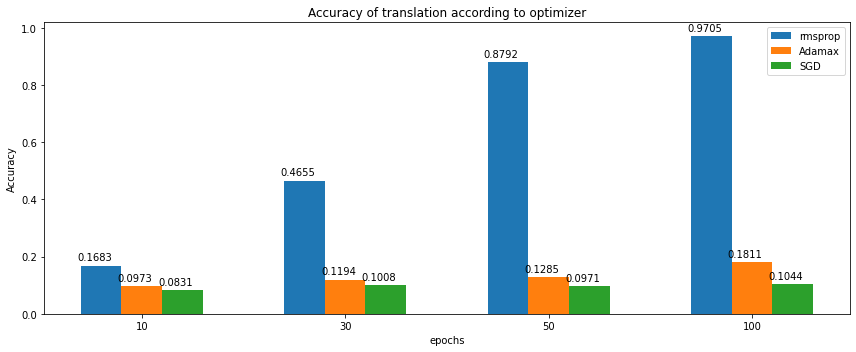

In [ ]:
labels = [10,30,50,100]


x = np.arange(len(labels))  
width = 0.2  

fig, ax = plt.subplots(figsize=(12,5))
rects1 = ax.bar(x - width, accuracy_500_10, width, label='rmsprop')
rects2 = ax.bar(x , accuracy_Adamax, width, label='Adamax')
rects3 = ax.bar(x + width, accuracy_SGD, width, label='SGD')


ax.set_xlabel('epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of translation according to optimizer')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 3, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()


plt.show()

### Comparison with existing models

In [ ]:
#With a bach size of 10
accuracy_simple_RNN_500_10 = [0.7837 ,0.7952 ,0.8052 ,0.8284 ]
accuracy_bidirectional_RNN_500_10 = [0.7946 , 0.7928 ,0.8148 ,0.8611 ]

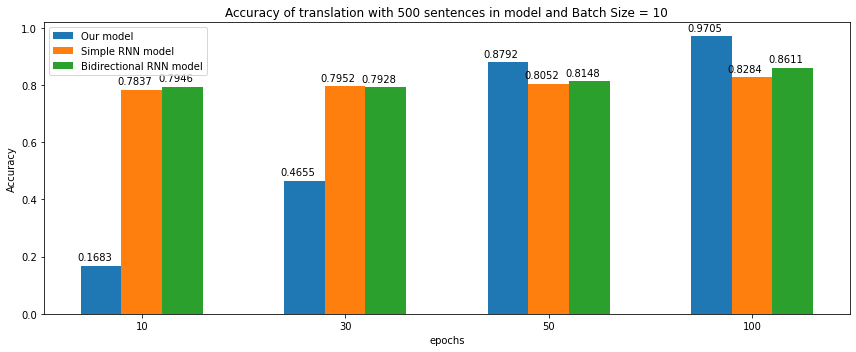

In [ ]:
labels = [10,30,50,100]


x = np.arange(len(labels))  
width = 0.2  

fig, ax = plt.subplots(figsize=(12,5))
rects1 = ax.bar(x - width, accuracy_500_10, width, label='Our model')
rects2 = ax.bar(x , accuracy_simple_RNN_500_10, width, label='Simple RNN model')
rects3 = ax.bar(x + width, accuracy_bidirectional_RNN_500_10, width, label='Bidirectional RNN model')


ax.set_xlabel('epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of translation with 500 sentences in model and Batch Size = 10')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 3, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()


plt.show()

In [ ]:
#With a bach size of 100
accuracy_simple_RNN_500_100 = [0.7852 ,0.7784 ,0.7877 ,0.7973 ]
accuracy_bidirectional_RNN_500_100 = [0.7942 ,0.8001 ,0.7934 ,0.8003 ]

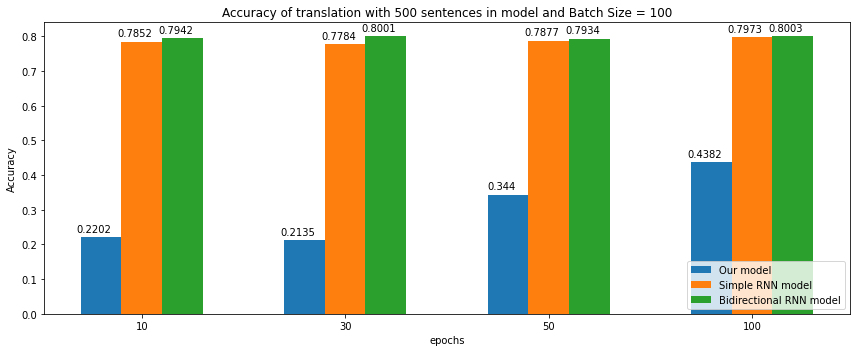

In [ ]:
labels = [10,30,50,100]


x = np.arange(len(labels))  
width = 0.2 

fig, ax = plt.subplots(figsize=(12,5))
rects1 = ax.bar(x - width, accuracy_500_100, width, label='Our model')
rects2 = ax.bar(x , accuracy_simple_RNN_500_100, width, label='Simple RNN model')
rects3 = ax.bar(x + width, accuracy_bidirectional_RNN_500_100, width, label='Bidirectional RNN model')


ax.set_xlabel('epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of translation with 500 sentences in model and Batch Size = 100')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 3, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()


plt.show()

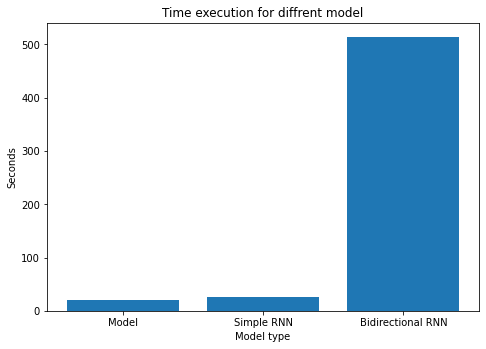

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Model_used = ['Model' , 'Simple RNN', 'Bidirectional RNN']
time_execution = [21.08,26.24,514.7]
ax.bar(Model_used,time_execution)

ax.set_xlabel('Model type')
ax.set_ylabel('Seconds')
ax.set_title('Time execution for diffrent model')

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bebb3e79-aea8-4efb-939c-d2e0c5fd898b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>